<a href="https://colab.research.google.com/github/Matans844/img2capt-Deep-Learning-Image-Caption-Generator/blob/main/img2capt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project
Hands-on section of the final assignment in the Deep Learning course, semester A, 2020, at IDC.

**Taught by**: Dr. Kfir Bar.

Prepared by Matan Sheskin, I.D.#: 304826811

## Goal
Laveraging CNN with LSTM (through RNN) to generate captions for images.




---



---



# Implementation

## Part 1: Fetch datasets
We import the dataset from the Open Images dataset. This dataset includes training images, their annotations, and a validation dataset.

### Step 1: Imports
Here we import the relevant packages, define the device, and fetch the JSON file that contains infromation about the images to download.

In [ ]:
!pip install -qU openimages torch_snippets urllib3
!pip install torchtext==0.4
!pip install pytorch-lightning

     |████████████████████████████████| 153kB 22.5MB/s 
     |████████████████████████████████| 133kB 34.8MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 204kB 34.7MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 7.5MB 44.1MB/s 
     |████████████████████████████████| 296kB 69.1MB/s 
     |████████████████████████████████| 144.2MB 33kB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 133kB 14.0MB/s 
ERROR: datascience 0.10.6 has requiremen

In [ ]:
from torch_snippets import *
import json

!wget -O open_images_train_captions.jsonl -q https://storage.googleapis.com/localized-narratives/annotations/open_images_train_v6_captions.jsonl

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[05/01/21 12:40:21] WARNING  sklearn is not found. Skipping relevant  ]8;id=1619872821.4757795-375623;file:///usr/local/lib/python3.7/dist-packages/torch_snippets/__init__.py\__init__.py]8;;\:<module>:13
                             imports from submodule `sklegos`                                
                             Exception: No module named 'sklego'

### Step 2: Getting N images
By looping through the JSON file, we fetch information about the first N images.

In [ ]:
with open('open_images_train_captions.jsonl', 'r') as json_file:
    json_list = json_file.read().split('\n')

np.random.shuffle(json_list)
data = []
N = 50000

for ix, json_str in Tqdm(enumerate(json_list), N):
    if ix == N: break
    try:
      result = json.loads(json_str)
      x = pd.DataFrame.from_dict(result, orient='index').T
      data.append(x)
    except:
      pass

100%|█████████▉| 49985/50000 [00:43<00:00, 1219.67it/s]

A sample of the JSON file can be seen here:

In [ ]:
print(json_str)

{"dataset_id": "open_images", "image_id": "3caa00d2d7403d0e", "annotator_id": 48, "caption": 
"Here we can see woman face and wore chain."}

From this sample, we see that `image_id` and `caption` can be used in the subsequent steps:


*   `image_id` will be used to fetch the corresponding image.
*   `caption` will be used to associate the output corresponding to th eimage obtained from a given image ID.



### Step 3: Splitting data to train dataset and test dataset

In [ ]:
np.random.seed(10)
data = pd.concat(data)
data['train'] = np.random.choice([True,False], size=len(data), p=[0.95,0.05])
data.head()
data.to_csv('data.csv', index=False)


### Step 4: Getting images from JSON
Using image IDs in the JSON file, we download images for our train and test datasets.


In [ ]:
from openimages.download import _download_images_by_id
!mkdir -p train-images test-images

In [ ]:
# downloading train datasets
subset_imageIds = data[data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './train-images/')

Streaming output truncated to the last 5000 lines.
100%|██████████| 47533/47533 [21:19<00:00, 37.16it/s]


In [ ]:
# downloading test datasets
subset_imageIds = data[~data['train']].image_id.tolist()
_download_images_by_id(subset_imageIds, 'train', './test-images/')


100%|██████████| 2467/2467 [01:06<00:00, 37.12it/s]


---

## Part 2: Creating a vocabulary 
For every unique word in every caption, we create a vocabulary to a unique integer.

### Step 1: A torchtext vocabulary object
We will use the `Field.build_vocab` functionality in the `torchtext` library. It runs through all the words (in captions) and accumulates them into two counters:


1.   String to int (`stoi`) dictionary.
2.   Int to string (`itos`) list.

We would like to use tensors for words in order to develop our NLP dataset. However, strings are incompatible with tensors. Thus, we need to keep track of all unique occurrences of words (also known as 'tokens'), so that we can create a one-to-one mapping of every word with a unique associated integer. This mapping will allow us to use tensors. `Field` for `captions` is a specialized object for performing this count.

**Note**: The first few tokens are reserved for special functionalities, such as padding, unknown, the start of a sentence, and the end of a sentence.



In [ ]:
from torchtext.data import Field
from pycocotools.coco import COCO
from collections import defaultdict

captions = Field(sequential=False, init_token='<start>', eos_token='<end>')
all_captions = data[data['train']]['caption'].tolist()
all_tokens = [[w.lower() for w in c.split()] for c in all_captions]
all_tokens = [w for sublist in all_tokens for w in sublist]
captions.build_vocab(all_tokens)


### Step 2: Looking forward at evaluation
For training, we only need the `captions` object. However, if we ever come across a token that was not present during training, we need to return a default value. For that reason we define a `defaultdict` for `vocab.stoi` in the following code box.

In [ ]:
class Vocab: pass
vocab = Vocab()
captions.vocab.itos.insert(0, '<pad>')
vocab.itos = captions.vocab.itos

# returning '<unk>' as default
vocab.stoi = defaultdict(lambda: captions.vocab.itos.index('<unk>'))
vocab.stoi['<pad>'] = 0

for s,i in captions.vocab.stoi.items():
    vocab.stoi[s] = i+1

---

## Part 3: The Captioning Dataset Class
To interact with captions, alongside their corresponding images, we define the `CaptioningData` class.


In [ ]:
from torchvision import transforms

class CaptioningData(Dataset):

    def __init__(self, root, df, vocab):
        # the dataframe obtained previously
        self.df = df.reset_index(drop=True)
        # the folder containing the images   
        self.root = root    
        # the vocab object for the current dataset
        self.vocab = vocab
        # the image transformation pipeline
        self.transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))]
        )

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        # fetching image and corresponding caption
        row = self.df.iloc[index].squeeze()
        id = row.image_id
        image_path = f'{self.root}/{id}.jpg'
        image = Image.open(os.path.join(image_path)).convert('RGB')
        # target is converted into a list of corresponding word IDs
        caption = row.caption
        tokens = str(caption).lower().split()
        target = []
        target.append(vocab.stoi['<start>'])
        target.extend([vocab.stoi[token] for token in tokens])
        target.append(vocab.stoi['<end>'])
        target = torch.Tensor(target).long()
        return image, target, caption

    def choose(self):
        return self[np.random.randint(len(self))]

    def __len__(self):
        return len(self.df)

    # method to work on a batch of data:
    # (1) calculate the caption with the maximum number of words.
    # (2) pad the rest of the captions in the batch to have the same length.   
    def collate_fn(self, data):
        data.sort(key=lambda x: len(x[1]), reverse=True)
        images, targets, captions = zip(*data)
        images = torch.stack([self.transform(image) for image in images], 0)
        lengths = [len(tar) for tar in targets]
        _targets = torch.zeros(len(captions), max(lengths)).long()
        for i, tar in enumerate(targets):
            end = lengths[i]
            _targets[i, :end] = tar[:end] 
        return images.to(device), _targets.to(device), torch.tensor(lengths).long().to(device)


---

## Part 4: Defining datasets and dataloaders for the datasets

### Step 1: Defining training and test datasets

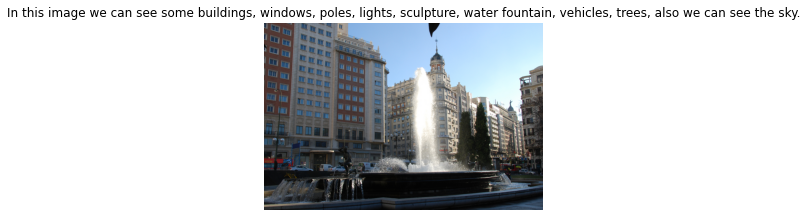

tensor([   2,    6,   15,   17,   13,   11,   10,   20,   91,  211,  129,  186,
        1274,   88, 1340,  273,   58,   48,   13,   11,   10,    4,   31,    3])

In [ ]:
trn_ds = CaptioningData('train-images', data[data['train']], vocab)
test_ds = CaptioningData('test-images', data[~data['train']], vocab)

image, target, caption = trn_ds.choose()
show(image, title=caption, sz=5); print(target)

### Step 2: Creating dataloaders for both datasets

Notice that `BATCH_SIZE` is set for `DataLoader`.

In [ ]:
BATCH_SIZE = 32

trn_dl = DataLoader(trn_ds, BATCH_SIZE, collate_fn=trn_ds.collate_fn)
test_dl = DataLoader(test_ds, BATCH_SIZE, collate_fn=test_ds.collate_fn)
inspect(*next(iter(trn_dl)), names='images,targets,lengths')

==================================================================

IMAGES:
Tensor  Shape: torch.Size([32, 3, 224, 224])    Min: -2.118     Max: 2.640      Mean: -0.171 
dtype: torch.float32

==================================================================

TARGETS:
Tensor  Shape: torch.Size([32, 103])    Min: 0.000      Max: 11697.000  Mean: 67.241    
dtype: torch.int64

==================================================================

LENGTHS:
Tensor  Shape: torch.Size([32]) Min: 11.000     Max: 103.000    Mean: 38.031    dtype: 
torch.int64

==================================================================

---
 ## Part 6: Defining the Encoder CNN

### Step 1: Modifying pre-trained ResNet-152

Here we fetch a pre-trained ResNet-152 model. Then we delete its last `fc` layer, connect it to a `Linear` layer of size embed_size. Finally, with `bn`, we pass it through batch normalization.


In [ ]:
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1] # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

### Step 2: Encoder class summary

In [ ]:
encoder = EncoderCNN(256).to(device)
!pip install torch_summary
from torchsummary import summary
print(summary(encoder,torch.zeros(32,3,224,224).to(device)))

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28]

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
├─Sequential: 1-1                        [-1, 2048, 1, 1]          --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-7              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-8              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-9              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-10             [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-11             [-1, 512, 28, 28]         280,064
|    └─Sequential: 2-7                   [-1, 1024, 14, 14]        --
|    |    └─Bottleneck: 3-12             [-1, 1024, 14, 14]        1,512,448
|    |    └─Bottleneck: 3-13             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-14             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-15             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-16             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-17             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-18             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-19             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-20             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-21             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-22             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-23             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-24             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-25             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-26             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-27             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-28             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-29             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-30             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-31             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-32             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-33             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-34             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-35             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-36             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-37             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-38             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-39             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-40             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-41             [-1, 1024, 14, 14]        1,117,184
|    |    └─Bottleneck: 3-42             [-1, 1

---

## Part 7: Defining the Decoder RNN

In [ ]:
class DecoderRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=80):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # embed is a vocab matrix that creates and learns a unique embedding for each word
        self.embed = nn.Embedding(vocab_size, embed_size)
        # lstm returns a hidden state for each time step based on:
        # (1) Output of CNNEncoder.
        # (2) The previous time setp's word output embedding.
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        # linear converts each hidden state into a vector we can use softmax on,
        # to get the likely word for a time step.
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
      
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        # features come from the EncoderCNN
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # packing concatenated embeddings to avoid unrolling at time steps where
        # padding is present (this improves efficiency of RNN computations)
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True) 
        outputs, _ = self.lstm(packed)
        # sending LSTM outputs through a linear layer
        # the number of dimensions changes from 512 to vocab size
        outputs = self.linear(outputs[0])
        return outputs

    # to obtain image captinos after training, 'predict':
    # (1) it accepts eatures from EncoderCNN
    # (2)returns the expected tokens for each feature.
    def predict(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(self.max_seq_length):
            # hiddens: (batch_size, 1, hidden_size)
            hiddens, states = self.lstm(inputs, states) 
            # outputs: (batch_size, vocab_size)
            outputs = self.linear(hiddens.squeeze(1)) 
            # predicted: (batch_size)
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            # captions are converted into embedding
            # inputs: (batch_size, embed_size)
            inputs = self.embed(predicted)
            # inputs: (batch_size, 1, embed_size)
            inputs = inputs.unsqueeze(1) 
        # sampled_ids: (batch_size, max_seq_length)
        sampled_ids = torch.stack(sampled_ids, 1) 

        # convert predicted tokens to strings
        sentences = []
        for sampled_id in sampled_ids:
            sampled_id = sampled_id.cpu().numpy()
            sampled_caption = []
            for word_id in sampled_id:
                word = vocab.itos[word_id]
                sampled_caption.append(word)
                if word == '<end>':
                    break
            sentence = ' '.join(sampled_caption)
            sentences.append(sentence)
        return sentences

---

## Part 8: Defining training and evaluating on data batch


### Part 1: For training

`packed_padded_sequence` helps to pack predictions in a data structure that makes it easier to call `nn.CrossEntropyLoss` on the output with the packed `target` values.

In [ ]:
def train_batch(data, encoder, decoder, optimizer, criterion):
    encoder.train()
    decoder.train()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    # packed target values more suitable for nn.CrossEntropyLoss
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

### Step 2: For evaluation

In [ ]:
@torch.no_grad()
def eval_batch(data, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()
    images, captions, lengths = data
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths.cpu(), batch_first=True)[0]
    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    return loss

---

## Part 9: Model execution

### Step 1: Defining the model
Here we define model objects, loss function, and an optimizer.
We use increasing epochs to train the model.

In [ ]:
# model objects
encoder = EncoderCNN(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab.itos), 1).to(device)
# loss function
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
# optimizer (with learning rate)
optimizer = torch.optim.AdamW(params, lr=1e-3)
# epoch size
n_epochs = 10
log = Report(n_epochs)

### Step 2: Training the model

EPOCH: 1.000	trn_loss: 2.572	test_loss: 2.161	(1241.48s - 11173.34s remaining)
EPOCH: 2.000	trn_loss: 2.010	test_loss: 1.977	(2413.31s - 9653.26s remaining)
EPOCH: 3.000	trn_loss: 1.812	test_loss: 1.901	(3552.46s - 8289.07s remaining)
EPOCH: 4.000	trn_loss: 1.673	test_loss: 1.867	(4712.23s - 7068.34s remaining)
EPOCH: 5.000	trn_loss: 1.564	test_loss: 1.861	(5854.80s - 5854.80s remaining)
EPOCH: 6.000	trn_loss: 1.439	test_loss: 1.822	(7029.08s - 4686.05s remaining)
EPOCH: 7.000	trn_loss: 1.405	test_loss: 1.818	(8195.14s - 3512.20s remaining)
EPOCH: 8.000	trn_loss: 1.385	test_loss: 1.819	(9348.41s - 2337.10s remaining)
EPOCH: 9.000	trn_loss: 1.369	test_loss: 1.821	(10506.84s - 1167.43s remaining)
EPOCH: 9.974	test_loss: 1.815	(11669.59s - 30.00s remaining)


  0%|          | 0/111 [00:00<?, ?it/s]

EPOCH: 10.000	trn_loss: 1.354	test_loss: 1.821	(11670.41s - 0.00s remaining)



100%|██████████| 111/111 [00:00<00:00, 167.53it/s]


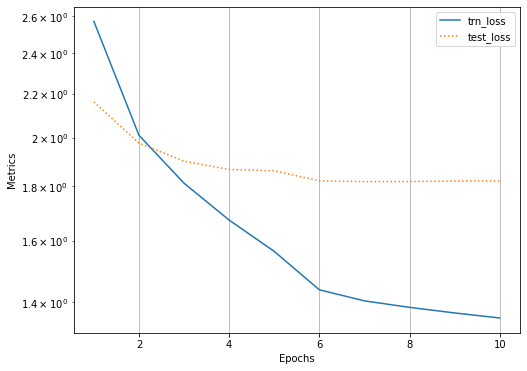

In [ ]:
for epoch in range(n_epochs):
    if epoch == 5: optimizer = torch.optim.AdamW(params, lr=1e-4)
    N = len(trn_dl)
    for i, data in enumerate(trn_dl):
        trn_loss = train_batch(data, encoder, decoder, optimizer, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, trn_loss=trn_loss, end='\r')

    N = len(test_dl)
    for i, data in enumerate(test_dl):
        test_loss = eval_batch(data, encoder, decoder, criterion)
        pos = epoch + (1+i)/N
        log.record(pos=pos, test_loss=test_loss, end='\r')

    log.report_avgs(epoch+1)

log.plot_epochs(log=True)

---

## Step 10: Generating predictions
Given an image, our model can now generate predictions.

[05/01/21 16:43:18] INFO     2467 files found at  ]8;id=1619887398.7009525-581544;file://<ipython-input-21-4f7c2ffb7e49>\<ipython-input-21-4f7c2ffb7e49>]8;;\:<module>:25
                             test-images

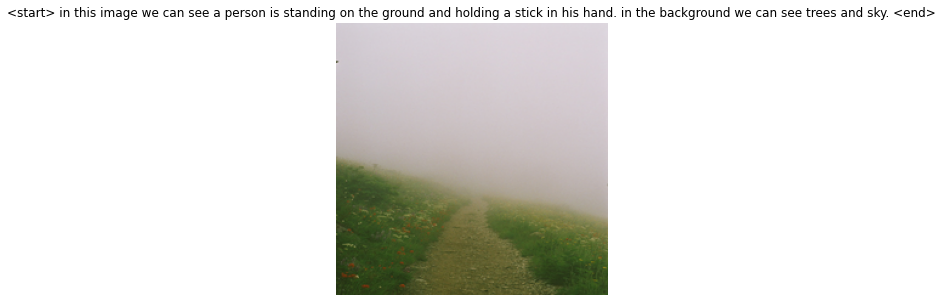

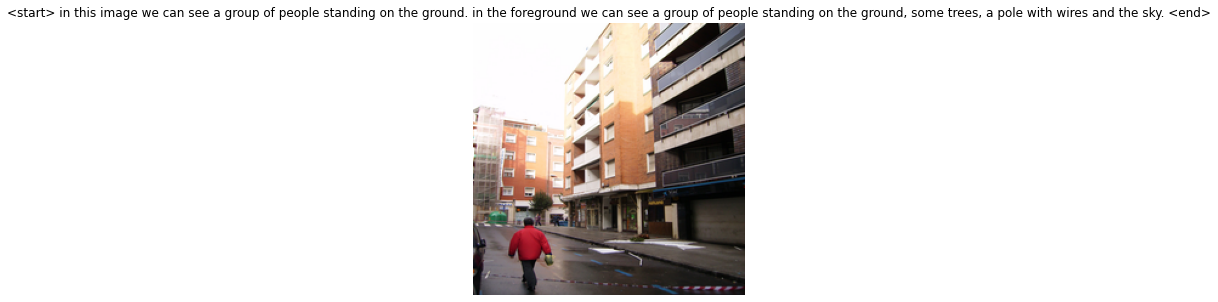

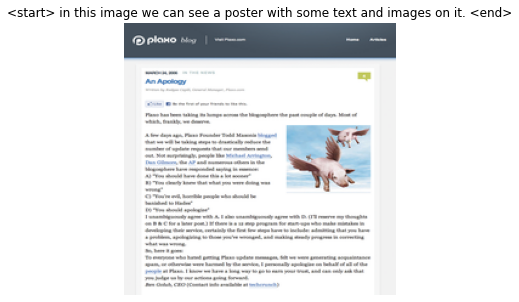

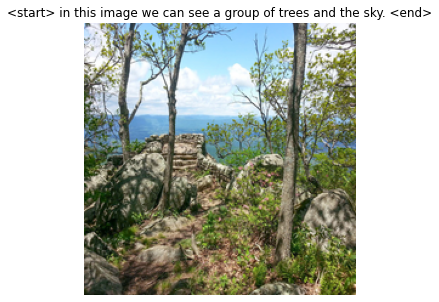

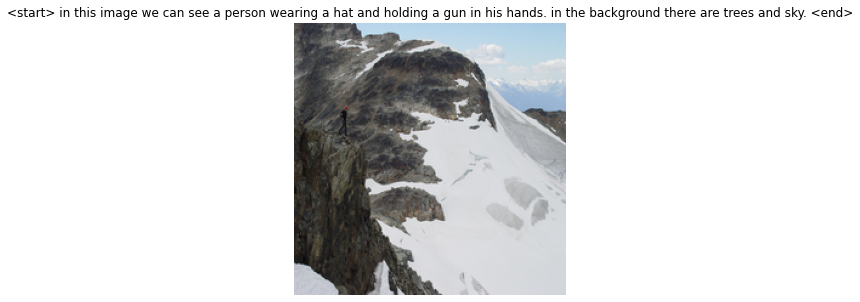

In [ ]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        tfm_image = transform(image)[None]
    return image, tfm_image

@torch.no_grad()
def load_image_and_predict(image_path):
    transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])

    org_image, tfm_image = load_image(image_path, transform)
    image_tensor = tfm_image.to(device)
    encoder.eval()
    decoder.eval()
    feature = encoder(image_tensor)
    sentence = decoder.predict(feature)[0]
    show(org_image, title=sentence)
    return sentence

files = Glob('test-images')
for _ in range(5):
    load_image_and_predict(choose(files))




---



---




# End